In [ ]:
'''
Author: Mingxin Zhang m.zhang@hapis.u-tokyo.ac.jp
Date: 2023-03-06 03:29:29
LastEditors: Mingxin Zhang
LastEditTime: 2023-04-12 01:54:25
Copyright (c) 2023 by Mingxin Zhang, All Rights Reserved. 
'''

'\nAuthor: Mingxin Zhang m.zhang@hapis.u-tokyo.ac.jp\nDate: 2023-03-06 03:29:29\nLastEditors: Mingxin Zhang\nLastEditTime: 2023-04-12 01:54:25\nCopyright (c) 2023 by Mingxin Zhang, All Rights Reserved. \n'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import itertools

In [3]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=0)
        self.bn2 = nn.BatchNorm2d(32)

        self.pool = nn.MaxPool2d(2)

        self.flatten = nn.Flatten(start_dim=1)

        self.fc1 = nn.Linear(32 * 1 * 23, encoded_space_dim)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = F.relu(self.bn1(x))
        x = self.pool(self.conv3(x))
        x = F.relu(self.bn2(x))
        x = self.flatten(x)

        x = self.fc1(x)
        return x


class Decoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.fc1 = nn.Linear(encoded_space_dim, 32 * 1 * 23)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 1, 23))

        self.deconv1 = nn.ConvTranspose2d(32, 16, 5, stride=2, output_padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.deconv2 = nn.ConvTranspose2d(16, 8, 5, stride=2, padding=2, output_padding=1)
        self.bn2 = nn.BatchNorm2d(8)
        self.deconv3 = nn.ConvTranspose2d(8, 1, 3, padding=1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.unflatten(x)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = self.deconv3(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.fc1 = nn.Linear(encoded_space_dim, 16)
        self.fc2 = nn.Linear(16, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

In [17]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

with open('/content/drive/MyDrive/Colab Notebooks/vibrotactile-encoder/trainset.pickle', 'rb') as file:
# with open('trainset.pickle', 'rb') as file:
    trainset = pickle.load(file)

spectrogram = torch.from_numpy(trainset['spectrogram'].astype(np.float32))
texture = trainset['texture']
le = preprocessing.LabelEncoder()
labels = torch.as_tensor(le.fit_transform(texture))

train_dataset = torch.utils.data.TensorDataset(spectrogram, labels) 
train_dataloader = torch.utils.data.DataLoader( 
    dataset = train_dataset, 
    batch_size = 64,
    shuffle = True, 
    num_workers = 2, 
    ) 

mse = nn.MSELoss()
adversarial_loss = nn.BCELoss()

FEAT_DIM = 16
encoder = Encoder(encoded_space_dim = FEAT_DIM)
decoder = Decoder(encoded_space_dim = FEAT_DIM)
discriminator = Discriminator(encoded_space_dim = FEAT_DIM)

gen_lr = 5e-4
reg_lr = 5e-4

optimizer_G_Enc = optim.Adam(encoder.parameters(), lr=gen_lr)
optimizer_Dec = optim.Adam(decoder.parameters(), lr=gen_lr)

optimizer_G_Gen = optim.Adam(encoder.parameters(), lr=reg_lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=reg_lr)

encoder.to(device)
decoder.to(device)
discriminator.to(device)

epoch_num = 150

Selected device: cuda


In [18]:
EPS = 1e-15

for epoch in range(1, epoch_num + 1):
    encoder.train()
    decoder.train()
    discriminator.train()

    for i, (img, label) in enumerate(train_dataloader):
        img = torch.unsqueeze(img, 1) # Add channel axis (1 channel)
        img = img.to(device)

        encoder.zero_grad()
        decoder.zero_grad()
        discriminator.zero_grad()

        # 1) reconstruction
        z_gen = encoder(img)
        img_pred = decoder(z_gen)
        recon_loss = mse(img_pred+EPS, img+EPS)

        recon_loss.backward()
        optimizer_G_Enc.step()
        optimizer_Dec.step()

        # 2) discriminator
        encoder.eval()

        real_z = torch.autograd.Variable(torch.Tensor(np.random.normal(0, 1, (img.shape[0], FEAT_DIM)))).to(device)
        fake_z = encoder(img)

        D_real_gauss = discriminator(real_z)
        D_fake_gauss = discriminator(fake_z)

        D_loss = -torch.mean(torch.log(D_real_gauss + EPS) + torch.log(1 - D_fake_gauss + EPS))
        D_loss.backward()
        optimizer_D.step()

        # generator
        encoder.train()
        fake_z = encoder(img)
        D_fake_gauss = discriminator(fake_z)
        G_loss = -torch.mean(torch.log(D_fake_gauss + EPS))
        G_loss.backward()
        optimizer_G_Gen.step()

    print('Epoch: ', epoch, 'Reconstruction Loss: ', recon_loss.item(), 'Discriminator Loss: ', D_loss.item(), 'Generator Loss: ', G_loss.item())

torch.save(encoder.state_dict(), '/content/drive/MyDrive/Colab Notebooks/vibrotactile-encoder/encoder_' + str(FEAT_DIM) + 'd.pt')
torch.save(decoder.state_dict(), '/content/drive/MyDrive/Colab Notebooks/vibrotactile-encoder/decoder_' + str(FEAT_DIM) + 'd.pt')
torch.save(discriminator.state_dict(), '/content/drive/MyDrive/Colab Notebooks/vibrotactile-encoder/discriminator_' + str(FEAT_DIM) + 'd.pt')

Epoch:  1 Reconstruction Loss:  467.4308776855469 Discriminator Loss:  0.42607346177101135 Generator Loss:  1.234043002128601
Epoch:  2 Reconstruction Loss:  117.53299713134766 Discriminator Loss:  0.640678882598877 Generator Loss:  1.4427525997161865
Epoch:  3 Reconstruction Loss:  62.42127990722656 Discriminator Loss:  0.976428210735321 Generator Loss:  1.2624231576919556
Epoch:  4 Reconstruction Loss:  55.856040954589844 Discriminator Loss:  0.5720721483230591 Generator Loss:  1.414108157157898
Epoch:  5 Reconstruction Loss:  59.49449920654297 Discriminator Loss:  0.7791957855224609 Generator Loss:  1.679568886756897
Epoch:  6 Reconstruction Loss:  52.40119171142578 Discriminator Loss:  0.5669464468955994 Generator Loss:  1.8839222192764282
Epoch:  7 Reconstruction Loss:  51.79205322265625 Discriminator Loss:  0.7734760642051697 Generator Loss:  1.9254671335220337
Epoch:  8 Reconstruction Loss:  49.8733024597168 Discriminator Loss:  0.7292931079864502 Generator Loss:  1.685357093811

In [19]:
encoder = Encoder(encoded_space_dim = FEAT_DIM)
decoder = Decoder(encoded_space_dim = FEAT_DIM)

encoder_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/vibrotactile-encoder/encoder_' + str(FEAT_DIM) + 'd.pt', map_location=torch.device('cpu'))
encoder_dict = {k: v for k, v in encoder_dict.items()}

decoder_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/vibrotactile-encoder/decoder_' + str(FEAT_DIM) + 'd.pt', map_location=torch.device('cpu'))
decoder_dict = {k: v for k, v in decoder_dict.items()}

encoder.load_state_dict(encoder_dict)
decoder.load_state_dict(decoder_dict)

<All keys matched successfully>

In [22]:
encoder.eval()
decoder.eval()
encoder.to(device)
decoder.to(device)

correct = torch.zeros(1).squeeze().to(device)
total = torch.zeros(1).squeeze().to(device)

test_img = []
test_trues = []
vib_feat = []
reconstruct_spec = []

with torch.no_grad():
    for i, (img, label) in enumerate(train_dataloader):
        img = torch.unsqueeze(img, 1) # Add channel axis (1 channel)
        img = img.to(device)
        label = label.to(device)

        feat = encoder(img)
        pred_img = decoder(feat)

        autoencoder_loss = mse(pred_img, img)

        test_trues.extend(label.detach().cpu().numpy())
        vib_feat.extend(feat.detach().cpu().numpy())
        reconstruct_spec.extend(pred_img.detach().cpu().numpy())
        test_img.extend(img.detach().cpu().numpy())

print('Autoencoder Loss: ', autoencoder_loss.item())

Autoencoder Loss:  88.40476989746094


In [23]:
feat_dict = {'original_vib': test_img,
             'labels': test_trues,
             'vib_feat': vib_feat,
             'decoded_vib': reconstruct_spec
             }

file = open('/content/drive/MyDrive/Colab Notebooks/vibrotactile-encoder/feat_dict_' + str(FEAT_DIM) + 'd.pickle', 'wb')
pickle.dump(feat_dict, file)
file.close()

with open('/content/drive/MyDrive/Colab Notebooks/vibrotactile-encoder/feat_dict_' + str(FEAT_DIM) + 'd.pickle', 'rb') as file:
    feat_dict = pickle.load(file)

True label:  4


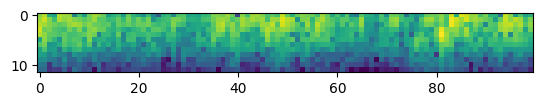

In [24]:
index = np.random.randint(0, len(train_dataloader.dataset))
print('True label: ', test_trues[index])
plt.imshow(test_img[index].squeeze())

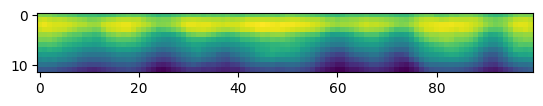

In [25]:
plt.imshow(reconstruct_spec[index].squeeze())

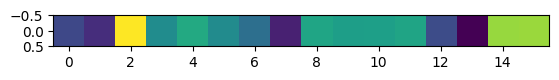

In [26]:
plt.imshow(np.expand_dims(vib_feat[index], axis=0))